In [1]:
from analysis import correct_cross_outlier
from analysis import correct_lum_outlier
from analysis import detect_lum_outlier
from analysis import detect_cross_outlier
from analysis import detect_time_outliers
from glob import glob
from visualization import plot_traces
from wfield.io import frames_average_for_trials, mmap_dat, TiffStack

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# root = '/home/wrx/Data_WF/WF_WRX'
root = '/home/wrx/Data_DOM/Widefield'
mouse_id = 'X2'
date = '20250416'
date_folder = os.path.join(root, mouse_id, date)
treatment = 'DOM'
folder = os.path.join(date_folder, treatment)

Convert tiff file to binary file<br>
for faster reading and processing

In [3]:
# Note: there should be only one tif in the folder,
# and no .bin file in the folder before running this cell
for path in [folder]:
    print(path)
    _ls = os.listdir(path)
    if np.array([_.endswith('.bin') for _ in _ls]).any():
        raise Warning('There are .bin files in the folder, \
            please delete them before running this cell!')
    if np.array([_.endswith('.tif') for _ in _ls]).sum() > 1:
        raise Warning('There are more than one tif files in the folder, \
            please check the folder!')

    # set nchannels=1 for our 2 channel tif file
    tif_stack = TiffStack(path, nchannels=2) 
    print('The frames of the stack:', tif_stack.shape[0])
    if tif_stack.shape[0] == 0:
        raise ValueError('The shape of the stack may be wrong!')
    tif_stack.export_binary(foldername=path, basename=f'{tif_stack.shape[0]}')

/home/wrx/Data_DOM/Widefield/X2/20250416/DOM


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 183.57it/s]


The frames of the stack: 36000


Exporting binary: 100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


In [4]:
# Calculate the frame rate according the time stamp
time_stamp_405 = np.loadtxt(glob(os.path.join(folder, '*-405Timestamp.csv'))[0],
    delimiter=',')
time_stamp_470 = np.loadtxt(glob(os.path.join(folder, '*-470Timestamp.csv'))[0],
    delimiter=',')
_len = min(len(time_stamp_405), len(time_stamp_470))
time_stamp_405 = time_stamp_405[:_len]
time_stamp_470 = time_stamp_470[:_len]

frame_rate = round(1000 / np.diff(time_stamp_405[: 10]).mean())
print('The frame rate:', frame_rate)

The frame rate: 10


In [5]:
parameters_path = os.path.join(folder, 'parameters.npy')
if os.path.exists(parameters_path):
    print('The parameters file exists')
    parameters = np.load(parameters_path, allow_pickle=True).item()
else:
    print('The parameters file does not exist')
    parameters = {}

parameters['frame_rate'] = frame_rate
np.save(parameters_path, parameters)

The parameters file exists


Mean of each frame

In [6]:
print('Calculating the mean of frames...')
frame_mean = np.mean(tif_stack, axis=(2, 3))

Calculating the mean of frames...


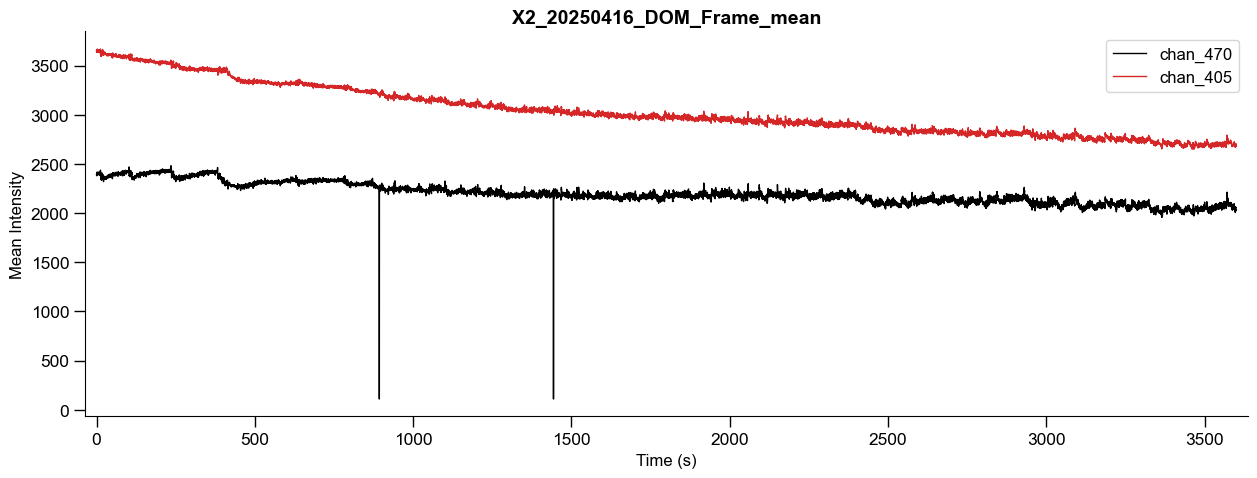

In [7]:
title = '{}_{}_{}_Frame_mean'.format(mouse_id, date, treatment)
labels = ['chan_470', 'chan_405']
plot_traces(frame_mean, data_rate=frame_rate, title=title, labels=labels,
    ylabel='Mean Intensity')

Correct the outlier

In [8]:
bin_path = glob(os.path.join(folder, '*.bin'))[0]
print(bin_path)
if not os.path.exists(bin_path):
    print(f'The file does not exist! \n {bin_path}')

/home/wrx/Data_DOM/Widefield/X2/20250416/DOM/36000_2_435_425_uint16.bin


In [37]:
# lum outlier detection and correction
outlier_index_470, outlier_index_405= detect_lum_outlier(frame_mean,
    lum_thr_coef=0.3, plot=False)
print('Outlier index 470:', outlier_index_470)
print('Outlier index 405:', outlier_index_405)

if len(outlier_index_470) > 0 or len(outlier_index_405) > 0:
    print("Outliers detected!")
    correct_lum_outlier(bin_path, outlier_index_470, outlier_index_405,
        plot=False, overwrite=True)

detect_lum_outlier: There are dim outliers frames detected!
Outlier index 470: [(8929, 8936), (14431, 14438)]
Outlier index 405: []
Outliers detected!
There are luminance outliers frames need to be corrected!
Luminance outliers frames corrected!


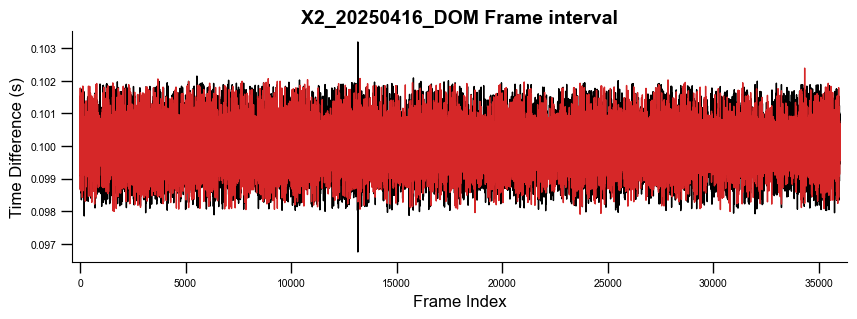

In [38]:
time_stamp = np.vstack((time_stamp_470, time_stamp_405)).T
time_diff = np.diff(time_stamp, axis=0)
title = '{}_{}_{} Frame interval'.format(mouse_id, date, treatment)
ylabel = 'Time Difference (s)'
xlabel = 'Frame Index'
plot_traces(time_diff*0.001, figsize=(10, 3), ylabel=ylabel, title=title,
    xlabel=xlabel)

In [39]:
interval = 1000 / frame_rate
print('The interval between frames:', interval, 'ms')

The interval between frames: 100.0 ms


In [40]:
outlier_index = detect_time_outliers(time_stamp_470, time_stamp_405, interval)
print('The outlier index:', outlier_index)

The outlier index: (array([], dtype=int64), array([], dtype=int64))


In [41]:
bin_file = glob(os.path.join(folder, '*.bin'))[0]
print('The bin file:', bin_file)

if outlier_index[0].size == 0 and outlier_index[1].size == 0:
    print('No outliers detected!')
    dat = mmap_dat(bin_path)
else:
    print('Outliers detected!')
    dat = correct_cross_outlier(bin_file, outlier_index_470=outlier_index[0],
        outlier_index_405=outlier_index[1], overwrite=True)

The bin file: /home/wrx/Data_DOM/Widefield/X2/20250416/DOM/36000_2_435_425_uint16.bin
No outliers detected!


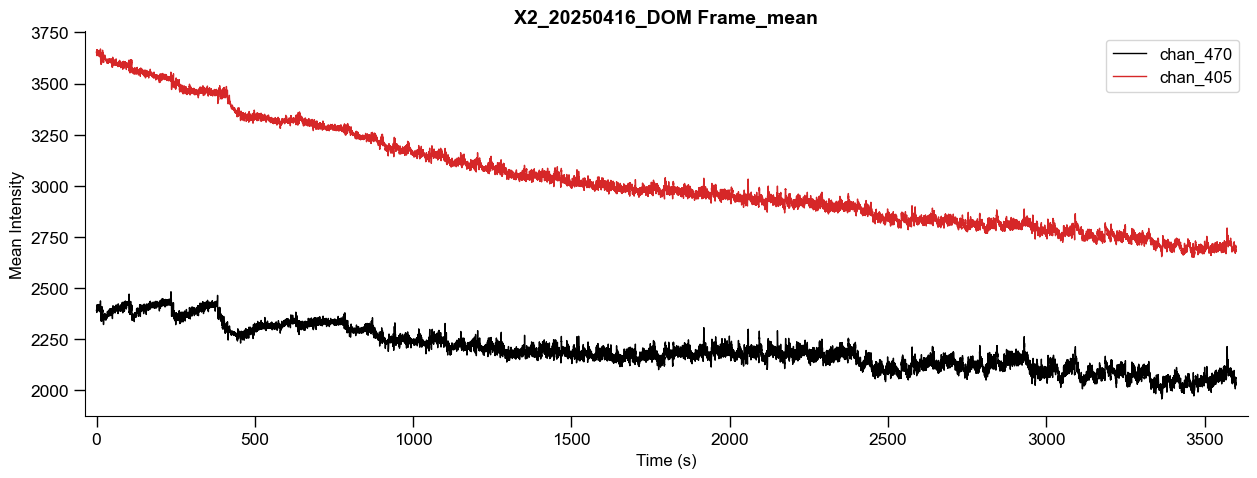

In [42]:
frame_mean = np.mean(dat, axis=(2, 3))

title = '{}_{}_{} Frame_mean'.format(mouse_id, date, treatment)
plot_traces(frame_mean, data_rate=frame_rate, title=title,
    labels=['chan_470', 'chan_405'], ylabel='Mean Intensity')

Save the frame mean value

In [43]:
# create a dataframe to store the time stamps
n_frames = min(len(frame_mean), len(time_stamp_470))
print('The number of frames:', n_frames)

csv_path = os.path.join(folder, 'results.csv')
if os.path.exists(csv_path):
    print('The csv file exists!')
    df = pd.read_csv(csv_path)
else:
    print('The csv file does not exist!')
    df = pd.DataFrame()

df['frame_mean_470'] = frame_mean[:n_frames, 0]
df['frame_mean_405'] = frame_mean[:n_frames, 1]
df['time_stamp_470'] = time_stamp_470[:n_frames]
df['time_stamp_405'] = time_stamp_405[:n_frames]

df.to_csv(csv_path, index=False)

The number of frames: 36000
The csv file does not exist!
